# Part-of-Speech (POS) Tagging

Implementation of POS tagging on the Penn treebank corpus using neural networks in Keras

In [208]:
#import libraries
import numpy as np
import nltk
from nltk.corpus import treebank
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import regularizers
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [122]:
#download treebank corpus
nltk.download('treebank')
np.random.seed(1)

[nltk_data] Downloading package treebank to /Users/peace/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


### Language Model (tokens and pos-tags)

In [190]:
#pos tagging sentences of treebank
sentences = treebank.tagged_sents()
sentences

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]

In [134]:
print('POS tags: ', set([pair[1] for sentence in sentences for pair in sentence]))
print('Total POS tags: ', len(set([pair[1] for sentence in sentences for pair in sentence])))

46

### Features Engineering

 There are in total 46 tags, thus our y label can have 46 possible outcomes.
 
 We will create feature vector corresponding to each word (token) in the sentence. For each token in a sentence, the feature set consists of following features:
 * **total_words**: length of the sentence it belongs to
 * **word**: token
 * **is_first**: boolean depending upon if the token is first word in the sentence or not
 * **is_last**: boolean depending upon if the token is last word in the sentence or not
 * **is_capitalized**: boolean depending upon if the first letter of token is a capital letter or not
 * **is_all_caps**: boolean depending upon if the token is capitalized or not
 * **is_all_lower**: boolean depending upon if the token is lower cased or not
 * **prefix-1**: first character of the token
 * **prefix-2**: first two characters of the token
 * **prefix-3**: first three characters of the token
 * **suffix-1**: last character of the token
 * **suffix-2**: last two characters of the token
 * **suffix-3**: last three characters of the token
 * **prev_word**: previous token, returns '' if it is the first token in the sentence
 * **next_word**: following token, returns '' if it is the last token in the sentence

In [191]:
#feature creation
def get_feature(sentence, idx):
    word = sentence[idx]
    
    return {
        'total_words': len(sentence),
        'word': word,
        'is_first': idx == 0,
        'is_last': idx == len(sentence) - 1,
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,
        'is_all_lower': word.lower() == word,
        'prefix-1': word[0],
        'prefix-2': word[:2],
        'prefix-3': word[:3],
        'suffix-1': word[-1],
        'suffix-2': word[-2:],
        'suffix-3': word[-3:],
        'prev_word': '' if idx == 0 else sentence[idx - 1],
        'next_word': '' if idx == len(sentence) - 1 else sentence[idx + 1]
    }

In [192]:
#preparing dataset
#extract words from (word,tag) pairs for a given sentence
def get_word(sentence):
        return [i[0] for i in sentence]

#creating features(x) and labels(y) 
def get_dataset(sentences):
    x, y = [], []
    for sentence in sentences:
        for idx, (word, tag) in enumerate(sentence):
            x.append(get_feature(get_word(sentence), idx))
            y.append(tag)
    return x, y         

Splitted the dataset into 80-20 train-test set

### Train-Test Split

In [193]:
#train test split
split = int(len(sentences)*.8)
train = sentences[: split]
test = sentences[split: ]

x_train, y_train = get_dataset(train)
x_test, y_test = get_dataset(test)

We need to vectorize the feature dictionary created for a given word above to make a input feature vectors for neural networks. Sklearn provides DictVectorizer class to convert a feature dictionary into a feature vector

### Features Set Encoding

In [194]:
#vectorizing x
dict_vectorize = DictVectorizer(sparse=False)
dict_vectorize.fit(x_train + x_test)

x_train = dict_vectorize.transform(x_train)
x_test = dict_vectorize.transform(x_test)

We have our y labeled as strings of POS. We will have to make them categorical and then convert them into one-hot encodings

### Labels Encoding

In [195]:
#encoding y labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
print(y_test)

[11 17 15 ... 15 20  7]


In [197]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [251]:
#visualizing created vectors'shapes
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (80637, 44232)
y_train shape:  (80637, 46)
x_test shape:  (20039, 44232)
y_test shape:  (20039, 46)


### Model Architecture

In [246]:
#define model architecture using keras
model = Sequential()
model.add(Dense(units=512, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_split=0.2, epochs=7, batch_size=256, verbose=1)
print(history.history.keys())

Train on 64509 samples, validate on 16128 samples
Epoch 1/7
64509/64509 [==============================] - 252s 4ms/step - loss: 3.6582 - acc: 0.7384 - val_loss: 0.6830 - val_acc: 0.8963
Epoch 2/7
64509/64509 [==============================] - 250s 4ms/step - loss: 0.5119 - acc: 0.9172 - val_loss: 0.4554 - val_acc: 0.9227
Epoch 3/7
64509/64509 [==============================] - 304s 5ms/step - loss: 0.3547 - acc: 0.9454 - val_loss: 0.3632 - val_acc: 0.9359
Epoch 4/7
64509/64509 [==============================] - 258s 4ms/step - loss: 0.2788 - acc: 0.9593 - val_loss: 0.3065 - val_acc: 0.9416
Epoch 5/7
64509/64509 [==============================] - 255s 4ms/step - loss: 0.2330 - acc: 0.9674 - val_loss: 0.3129 - val_acc: 0.9366
Epoch 6/7
64509/64509 [==============================] - 256s 4ms/step - loss: 0.2045 - acc: 0.9728 - val_loss: 0.2639 - val_acc: 0.9464
Epoch 7/7
64509/64509 [==============================] - 249s 4ms/step - loss: 0.1736 - acc: 0.9774 - val_loss: 0.2742 - val_acc

### Model Visualization

Text(0.5,1,'Training vs Validation Loss')

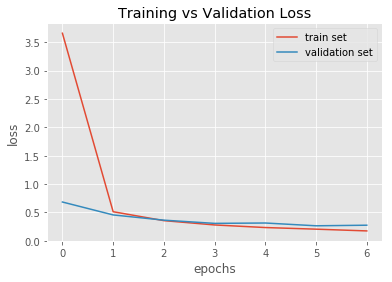

In [247]:
#visualizing train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Training vs Validation Loss')

Text(0.5,1,'Training vs Validation Accuarcy')

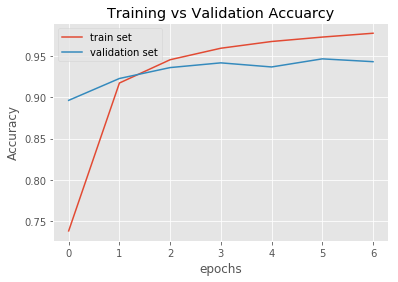

In [248]:
#visualizing train and validation Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train set', 'validation set'], loc='best')
plt.title('Training vs Validation Accuarcy')

### Model Evaluation

In [250]:
#evalute prediction
test_loss, accuracy = model.evaluate(x_test, y_test)

20039/20039 [==============================] - 42s 2ms/step


In [240]:
print(accuracy)

0.9279405159938121
